In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!git clone https://github.com/mingyuyng/DeepVO.git /content/DeepVO
%cd /content/DeepVO
print("Репозиторий mingyuyng/DeepVO склонирован в /content/DeepVO")

# Создаем главную папку для сохранения результатов
SAVE_RESULTS_DIR = '/content/DeepVO/_SAVE_RESULTS'
os.makedirs(SAVE_RESULTS_DIR, exist_ok=True)
print(f"Результаты будут сохраняться в: {SAVE_RESULTS_DIR}")

Cloning into '/content/DeepVO'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 77 (delta 15), reused 65 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 2.57 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/DeepVO
Репозиторий mingyuyng/DeepVO склонирован в /content/DeepVO
Результаты будут сохраняться в: /content/DeepVO/_SAVE_RESULTS


In [ ]:
%cd /content/DeepVO

/content/DeepVO


In [ ]:
DRIVE_COLOR_ZIP = '/content/drive/MyDrive/Webbee/data_odometry_color.zip'
DRIVE_POSES_ZIP = '/content/drive/MyDrive/Webbee/data_odometry_poses.zip'

# Папка назначения для датасета внутри проекта
DEST_DATA_DIR = "/content/DeepVO/dataset"
os.makedirs(DEST_DATA_DIR, exist_ok=True)
print(f"Данные будут распакованы в: {DEST_DATA_DIR}")

# Проверяем наличие файлов
if not os.path.exists(DRIVE_COLOR_ZIP):
    print(f"ОШИБКА: Файл не найден: {DRIVE_COLOR_ZIP}")
if not os.path.exists(DRIVE_POSES_ZIP):
    print(f"ОШИБКА: Файл не найден: {DRIVE_POSES_ZIP}")

print("\nРаспаковка data_odometry_color.zip...")
!unzip -q -o "{DRIVE_COLOR_ZIP}" -d /content/
print("Распаковка data_odometry_poses.zip...")
!unzip -q -o "{DRIVE_POSES_ZIP}" -d /content/

Данные будут распакованы в: /content/DeepVO/dataset

Распаковка data_odometry_color.zip...
Распаковка data_odometry_poses.zip...


In [ ]:
import shutil

# Перемещаем распакованные папки в структуру проекта /content/DeepVO/dataset
print("\nПеремещение файлов в структуру проекта...")
if os.path.exists('/content/dataset/sequences'):
    # shutil.move перезапишет папку назначения, если она существует
    if os.path.exists(f'{DEST_DATA_DIR}/sequences'):
        shutil.rmtree(f'{DEST_DATA_DIR}/sequences')
    shutil.move('/content/dataset/sequences', DEST_DATA_DIR)
    print("Папка 'sequences' перемещена успешно.")

if os.path.exists('/content/dataset/poses'):
    if os.path.exists(f'{DEST_DATA_DIR}/poses'):
        shutil.rmtree(f'{DEST_DATA_DIR}/poses')
    shutil.move('/content/dataset/poses', DEST_DATA_DIR)
    print("Папка 'poses' перемещена успешно.")

# Удаляем пустую папку /content/dataset
if os.path.exists('/content/dataset'):
    shutil.rmtree('/content/dataset')


Перемещение файлов в структуру проекта...
Папка 'sequences' перемещена успешно.
Папка 'poses' перемещена успешно.


In [ ]:
!python utils/preprocess.py

Transforming /content/DeepVO/dataset/poses/00.txt...
Video 00: shape=(4540, 6)
Transforming /content/DeepVO/dataset/poses/01.txt...
Video 01: shape=(1100, 6)
Transforming /content/DeepVO/dataset/poses/02.txt...
Video 02: shape=(4660, 6)
Transforming /content/DeepVO/dataset/poses/03.txt...
Video 03: shape=(800, 6)
Transforming /content/DeepVO/dataset/poses/04.txt...
Video 04: shape=(270, 6)
Transforming /content/DeepVO/dataset/poses/05.txt...
Video 05: shape=(2760, 6)
Transforming /content/DeepVO/dataset/poses/06.txt...
Video 06: shape=(1100, 6)
Transforming /content/DeepVO/dataset/poses/07.txt...
Video 07: shape=(1100, 6)
Transforming /content/DeepVO/dataset/poses/08.txt...
Video 08: shape=(4070, 6)
Transforming /content/DeepVO/dataset/poses/09.txt...
Video 09: shape=(1590, 6)
Transforming /content/DeepVO/dataset/poses/10.txt...
Video 10: shape=(1200, 6)
elapsed time = 1.446842908859253


In [ ]:
import os
import numpy as np
import time
from scipy.spatial.transform import Rotation as R

def cal_rel_pose_final(pose_pre_flat, pose_curr_flat):
    T_pre = np.identity(4)
    T_pre[:3, :] = np.array(pose_pre_flat).reshape(3, 4)

    T_curr = np.identity(4)
    T_curr[:3, :] = np.array(pose_curr_flat).reshape(3, 4)

    T_rel = np.linalg.inv(T_pre) @ T_curr

    translation = T_rel[:3, 3]
    rotation_matrix = T_rel[:3, :3]
    angles = R.from_matrix(rotation_matrix).as_euler('zyx')

    # angles[0]=yaw (Z), angles[1]=pitch (Y), angles[2]=roll (X)
    yaw, pitch, roll = angles[0], angles[1], angles[2]

    # Возвращаем в порядке [roll (X), pitch (Y), yaw (Z), tx, ty, tz]
    return np.concatenate(([roll, pitch, yaw], translation))


def create_relative_pose_data(input_dir, output_dir):
    sequences = [f.split('.')[0] for f in os.listdir(input_dir) if f.endswith('.txt')]
    start_t = time.time()

    print(f"Reading absolute poses from: {os.path.abspath(input_dir)}")
    print(f"Saving relative poses to:   {os.path.abspath(output_dir)}")

    for video in sorted(sequences):
        input_fn = os.path.join(input_dir, f'{video}.txt')
        print(f'Processing {input_fn}...')

        with open(input_fn) as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]  # Игнорируем пустые строки
            poses = []
            if len(lines) < 2:
                print(f"  -> Not enough poses. Skipping.")
                continue

            for i in range(1, len(lines)):
                values = [float(v) for v in lines[i].split(' ')]
                values_pre = [float(v) for v in lines[i-1].split(' ')]
                poses.append(cal_rel_pose_final(values_pre, values))

            poses = np.array(poses)
            output_fn = os.path.join(output_dir, f'{video}.npy')
            np.save(output_fn, poses)
            print(f'  -> Saved {output_fn}, shape={poses.shape}')

    print(f'Elapsed time = {time.time()-start_t:.2f} seconds')


if __name__ == '__main__':
    absolute_poses_dir = '/content/DeepVO/ground_truth_generated'
    relative_poses_dir = '/content/DeepVO/dataset/poses'

    if os.path.exists(relative_poses_dir):
        print(f"Очистка старых .npy файлов в {relative_poses_dir}...")
        for f in os.listdir(relative_poses_dir):
            if f.endswith('.npy'):
                os.remove(os.path.join(relative_poses_dir, f))

    os.makedirs(relative_poses_dir, exist_ok=True)
    create_relative_pose_data(absolute_poses_dir, relative_poses_dir)

Очистка старых .npy файлов в /content/DeepVO/dataset/poses...
Reading absolute poses from: /content/DeepVO/ground_truth_generated
Saving relative poses to:   /content/DeepVO/dataset/poses
Processing /content/DeepVO/ground_truth_generated/00.txt...
  -> Saved /content/DeepVO/dataset/poses/00.npy, shape=(4543, 6)
Processing /content/DeepVO/ground_truth_generated/01.txt...
  -> Saved /content/DeepVO/dataset/poses/01.npy, shape=(1169, 6)
Processing /content/DeepVO/ground_truth_generated/02.txt...
  -> Saved /content/DeepVO/dataset/poses/02.npy, shape=(4662, 6)
Processing /content/DeepVO/ground_truth_generated/04.txt...
  -> Saved /content/DeepVO/dataset/poses/04.npy, shape=(278, 6)
Processing /content/DeepVO/ground_truth_generated/05.txt...
  -> Saved /content/DeepVO/dataset/poses/05.npy, shape=(2761, 6)
Processing /content/DeepVO/ground_truth_generated/06.txt...
  -> Saved /content/DeepVO/dataset/poses/06.npy, shape=(1103, 6)
Processing /content/DeepVO/ground_truth_generated/07.txt...
  -

In [ ]:
!python train.py

Pose directory (for .npy): /content/DeepVO/dataset/poses/
Save path: experiments/kitti_on_gold_data
Pose directory (for .npy): /content/DeepVO/dataset/poses/
Save path: experiments/kitti_on_gold_data
Fine-tuning mode: False
Epochs: 130, LR: 0.001, Experiment: kitti_on_gold_data
Number of samples in training dataset:  2475
Number of samples in validation dataset:  460
Using CosineAnnealingLR scheduler.
Record loss in:  experiments/kitti_on_gold_data/records/t00020809_v0305_im192x640_s7_b12.txt
Epoch 1/130 | Current LR: 1.00e-03
Iteration: 20, Loss: 5.538, angle: 5.2094, trans: 0.328
Iteration: 40, Loss: 1.850, angle: 1.7889, trans: 0.061
Iteration: 60, Loss: 0.984, angle: 0.9315, trans: 0.052
Iteration: 80, Loss: 0.710, angle: 0.6743, trans: 0.036
Iteration: 100, Loss: 0.451, angle: 0.4269, trans: 0.024
Iteration: 120, Loss: 0.402, angle: 0.3541, trans: 0.048
Iteration: 140, Loss: 0.274, angle: 0.2548, trans: 0.019
Iteration: 160, Loss: 0.230, angle: 0.1933, trans: 0.036
Iteration: 180,

In [ ]:
!python test.py

Загрузка модели из: /content/DeepVO/experiments/kitti_original_params/models/t00020809_v030405060710_im192x640_s7_b12.model.latest
Результаты будут сохранены в: /content/DeepVO/_SAVE_RESULTS/kitti_original_params/results

Обработка последовательности: 03 (801 кадров)
100% 800/800 [00:30<00:00, 26.21it/s]
Траектория для 03 сохранена в /content/DeepVO/_SAVE_RESULTS/kitti_original_params/results/03.txt

Обработка последовательности: 04 (271 кадров)
100% 270/270 [00:10<00:00, 26.99it/s]
Траектория для 04 сохранена в /content/DeepVO/_SAVE_RESULTS/kitti_original_params/results/04.txt

Обработка последовательности: 05 (2761 кадров)
100% 2760/2760 [01:43<00:00, 26.75it/s]
Траектория для 05 сохранена в /content/DeepVO/_SAVE_RESULTS/kitti_original_params/results/05.txt

Обработка последовательности: 06 (1101 кадров)
100% 1100/1100 [00:40<00:00, 26.95it/s]
Траектория для 06 сохранена в /content/DeepVO/_SAVE_RESULTS/kitti_original_params/results/06.txt

Обработка последовательности: 07 (1101 кадро

In [ ]:
!python evaluation.py


Sequence: 03
Distance (m): 560.89
Max speed (km/h): 31.86
Average sequence translational RMSE (%):   9.4676
Average sequence rotational error (deg/m): 0.0662


Sequence: 04
Distance (m): 393.65
Max speed (km/h): 56.25
Average sequence translational RMSE (%):   13.7157
Average sequence rotational error (deg/m): 0.0355


Sequence: 05
Distance (m): 2205.58
Max speed (km/h): 40.91
Average sequence translational RMSE (%):   7.5213
Average sequence rotational error (deg/m): 0.0321


Sequence: 06
Distance (m): 1232.88
Max speed (km/h): 51.43
Average sequence translational RMSE (%):   10.8165
Average sequence rotational error (deg/m): 0.0304


Sequence: 07
Distance (m): 694.70
Max speed (km/h): 39.13
Average sequence translational RMSE (%):   6.0760
Average sequence rotational error (deg/m): 0.0242


Sequence: 10
Distance (m): 919.52
Max speed (km/h): 51.43
Average sequence translational RMSE (%):   10.9106
Average sequence rotational error (deg/m): 0.0446



In [ ]:
!python train.py --fine_tune

Pose directory (for .npy): /content/DeepVO/dataset/poses/
Save path: experiments/kitti_original_params
--- АКТИВИРОВАН РЕЖИМ ДООБУЧЕНИЯ (FINE-TUNING) ---
Pose directory (for .npy): /content/DeepVO/dataset/poses/
Save path: experiments/kitti_finetuned
Load model from: experiments/kitti_original_params/models/t00020809_v030405060710_im192x640_s7_b12.model.latest
Load optimizer from: experiments/kitti_original_params/models/t00020809_v030405060710_im192x640_s7_b12.optimizer.latest
Fine-tuning mode: True
Epochs: 20, LR: 1e-05, Experiment: kitti_finetuned
Number of samples in training dataset:  2475
Number of samples in validation dataset:  460
Using CosineAnnealingLR scheduler.
Loaded model from:  experiments/kitti_original_params/models/t00020809_v030405060710_im192x640_s7_b12.model.latest
⚠️ WARNING: Optimizer file not found at experiments/kitti_original_params/models/t00020809_v030405060710_im192x640_s7_b12.optimizer.latest. Using new optimizer.
Record loss in:  experiments/kitti_finetu

--- Проверка данных для последовательности 00 ---

✅ ОТЛИЧНО! Траектории совпадают.


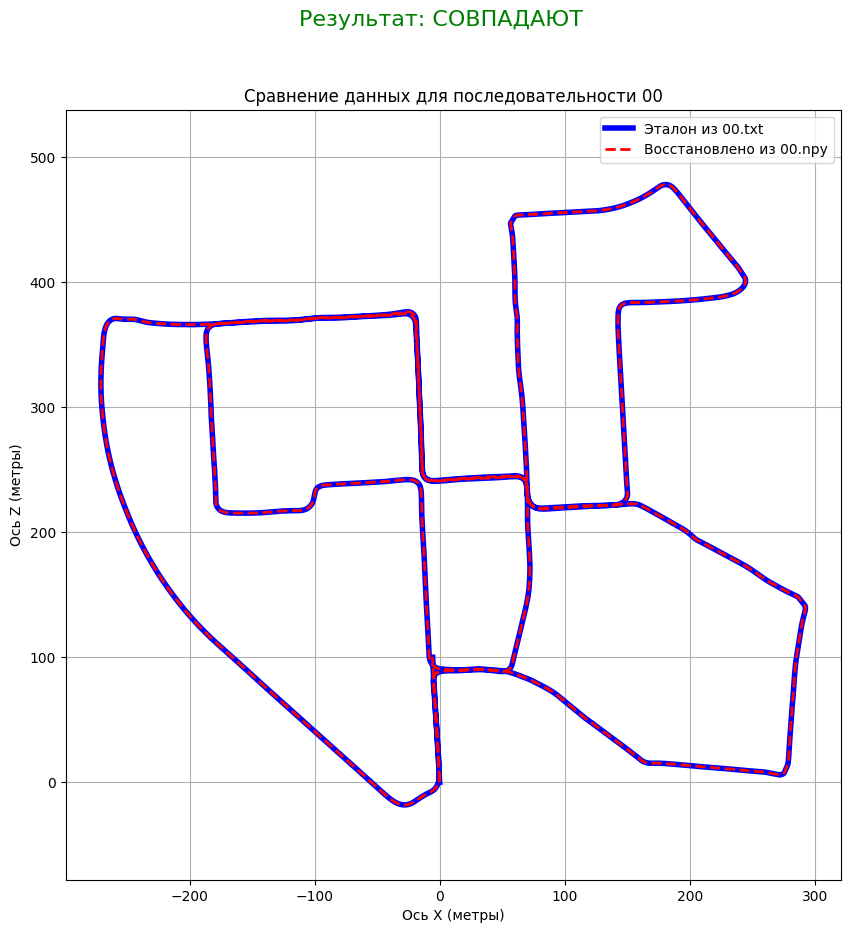

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

SEQUENCE_ID = '00'
GROUND_TRUTH_DIR = '/content/DeepVO/ground_truth_generated'
TRAINING_DATA_DIR = '/content/DeepVO/dataset/poses'


def reconstruct_trajectory_from_relative_final(relative_poses_6d):
    absolute_poses = [np.identity(4)]
    current_pose = np.identity(4)

    for rel_pose in relative_poses_6d:
        # Извлекаем roll, pitch, yaw и смещение
        roll, pitch, yaw, x, y, z = rel_pose

        T_rel = np.identity(4)

        # --- ГЛАВНОЕ ИЗМЕНЕНИЕ: Собираем матрицу вращения из углов в конвенции 'zyx' ---
        # Важно передать углы в том же порядке, в котором они были извлечены: [yaw (Z), pitch (Y), roll (X)]
        T_rel[:3, :3] = R.from_euler('zyx', [yaw, pitch, roll]).as_matrix()
        T_rel[:3, 3] = [x, y, z]

        current_pose = current_pose @ T_rel
        absolute_poses.append(current_pose)

    return absolute_poses


def main():
    print(f"--- Проверка данных для последовательности {SEQUENCE_ID} ---")

    txt_path = os.path.join(GROUND_TRUTH_DIR, f'{SEQUENCE_ID}.txt')
    npy_path = os.path.join(TRAINING_DATA_DIR, f'{SEQUENCE_ID}.npy')

    if not (os.path.exists(txt_path) and os.path.exists(npy_path)):
        print(f"Файлы не найдены.")
        return

    absolute_poses_gt = [np.vstack([np.array([float(v) for v in line.strip().split(' ')]).reshape(3, 4), [0, 0, 0, 1]]) for line in open(txt_path)]

    # Нормализация gt (на случай, если не identity)
    if len(absolute_poses_gt) > 0:
        T0 = absolute_poses_gt[0]
        absolute_poses_gt = [np.linalg.inv(T0) @ p for p in absolute_poses_gt]

    relative_poses_train = np.load(npy_path)
    absolute_poses_reconstructed = reconstruct_trajectory_from_relative_final(relative_poses_train)

    x_gt = [p[0, 3] for p in absolute_poses_gt]
    z_gt = [p[2, 3] for p in absolute_poses_gt]
    x_reconstructed = [p[0, 3] for p in absolute_poses_reconstructed]
    z_reconstructed = [p[2, 3] for p in absolute_poses_reconstructed]

    plt.figure(figsize=(10, 10))
    plt.plot(x_gt, z_gt, 'b-', linewidth=4, label=f'Эталон из {SEQUENCE_ID}.txt')
    plt.plot(x_reconstructed, z_reconstructed, 'r--', linewidth=2, label=f'Восстановлено из {SEQUENCE_ID}.npy')
    plt.title(f'Сравнение данных для последовательности {SEQUENCE_ID}')
    plt.xlabel('Ось X (метры)'); plt.ylabel('Ось Z (метры)')
    plt.legend(); plt.grid(True); plt.axis('equal')

    final_point_gt = np.array([x_gt[-1], z_gt[-1]])
    final_point_reconstructed = np.array([x_reconstructed[-1], z_reconstructed[-1]])

    if np.allclose(final_point_gt, final_point_reconstructed, atol=1e-3):
        print("\n✅ ОТЛИЧНО! Траектории совпадают.")
        plt.suptitle("Результат: СОВПАДАЮТ", fontsize=16, color='green')
    else:
        print(f"\n❌ НЕ СОВПАДАЮТ. Разница в конечной точке: {final_point_gt - final_point_reconstructed}")
        plt.suptitle("Результат: НЕ СОВПАДАЮТ", fontsize=16, color='red')
    plt.show()

if __name__ == '__main__':
    main()